# NTSB Aviation Accident Database Analysis

The following analysis looks at the NTSB Accident Database (linked here) and looks at accidents as a function of various database features, with the intention of identifying airplanes with a strong safety record that would be good to purchase for leasing purposes.

The features this analysis will focus on are:
*   Date of Accident
*   Airplane Make
*   Airplane Model
*   Aircraft Damage
*   Total Injuries
*   Total Fatalities
*   Phase of flight



## Data Cleaning

This particular analysis will look at the following features of the accident report.  

To begin, we will readin the data and clean up each of these features`

### Import the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#df = pd.read_csv("Data/Aviation_Data.csv")
df = pd.read_csv("https://raw.githubusercontent.com/jgoett2/AirplaneRecommendations/main/Data/Aviation_Data.csv")

<ipython-input-2-eb510d19be85>:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://raw.githubusercontent.com/jgoett2/AirplaneRecommendations/main/Data/Aviation_Data.csv")


In [3]:
df.groupby(["Make","Model"]).count().to_csv("Make.csv")

In [4]:
df["Model"]=df["Model"].map(lambda x:str(x))

### Date of Accident

Convert the string representation of Event.Date to a Pandas date-time object and store in same column.  Store the year in a new column "Year."

In [5]:
df["Event.Date"]=pd.to_datetime(df["Event.Date"], format="%Y-%m-%d")

df["Year"] = df["Event.Date"].dt.year

### Normalizing Make and Model

This analysis will concentrate on airplane models that are currently in production.  The dataframe models_of_interest holds data about these models.  
The database Make and Model values are updated to use consistent naming.

In [6]:
models_of_interest = pd.read_csv("https://raw.githubusercontent.com/jgoett2/AirplaneRecommendations/main/Data/ModelsOfInterest.csv")
models_of_interest["Model"]=models_of_interest["Model"].map(lambda x:str(x))

Update the make and model columns in the dataframe to use the standardized names above.

In [7]:
def normalize(name, normalized_names):
    for x in normalized_names:
        if x.lower() in str(name).lower():
            return x
    return name

df["Make"]=df["Make"].map(lambda x:str(x))
df["Model"]=df["Model"].map(lambda x:str(x))

df["Make"]=df["Make"].map(lambda x:normalize(x,models_of_interest["Make"].unique()))
df["Model"]=df["Model"].map(lambda x:normalize(x,models_of_interest["Model"].unique()))

models_of_interest["Make"].unique()


array(['Boeing', 'Airbus', 'Cessna', 'Piper', 'Embraer'], dtype=object)

Add type of aircraft to dataframe

### Injury and Fatality Records

Set blank records to a value of 0

In [8]:
df.loc[df["Total.Serious.Injuries"].isna(),"Total.Serious.Injuries"]=0
df.loc[df["Total.Fatal.Injuries"].isna(),"Total.Fatal.Injuries"]=0

### Removing Extraneous Records

Airplane Makes and Models that are not of interest are removed from the data set.

In [9]:
filter = df["Make"].map(lambda x:x in models_of_interest["Make"].unique())
df = df[filter]

filter = df["Model"].map(lambda x:x in models_of_interest["Model"].unique())
df = df[filter]

Add aircraft type to dataframe.

In [10]:
models_of_interest = models_of_interest.set_index(["Make","Model"])

In [11]:
df["Airplane.Type"]=df.apply(lambda x: models_of_interest.loc[(x["Make"],x["Model"])]["Type"], axis=1)

In [12]:
models_of_interest=models_of_interest.reset_index()

In [13]:
features_of_interest=["Event.Date","Year","Make","Model","Airplane.Type","Aircraft.damage","Total.Fatal.Injuries",
                      "Total.Serious.Injuries","Broad.phase.of.flight"]

In [14]:
df=df[features_of_interest]

In [15]:
df.to_csv("Airplane_data_clean.csv")

## Data Analysis

Analyze various features to support recommendations for aircraft purchase.

### Accidents vs. Time by Make

<Axes: >

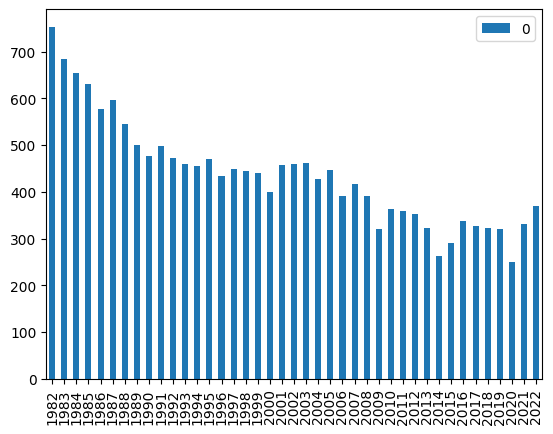

In [16]:
count, years = np.histogram(df[df["Year"].isna()==False]["Year"],bins=range(1982,2024,1))
pd.DataFrame(count,index=years[0:41]).plot.bar()

### Accidents vs. Time by Model and Type

### Wide-Body Aircraft

In [55]:
wide_body=df[df["Airplane.Type"]=="wide-body"]
all_accident_count=wide_body.groupby(["Model"]).count()["Event.Date"]

filter_serious_injury=wide_body["Total.Serious.Injuries"]>0
injury_accident_count=wide_body[filter_serious_injury].groupby(["Model"]).count()["Event.Date"]

filter_fatal_injury=wide_body["Total.Fatal.Injuries"]>0
fatal_accident_count=wide_body[filter_fatal_injury].groupby(["Model"]).count()["Event.Date"]


distribution=pd.concat([all_accident_count,injury_accident_count,fatal_accident_count],axis=1)
distribution.columns=["Accidents-All","Accidents-Serious Injury","Accidents-Fatal"]

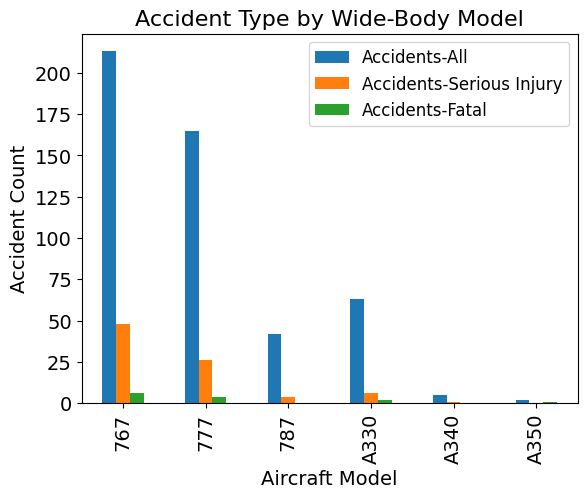

In [83]:
fig, ax=plt.subplots()
distribution.plot.bar(ax=ax, fontsize=14)

ax.set_title("Accident Type by Wide-Body Model", fontsize=16)
ax.set_xlabel("Aircraft Model", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)
ax.legend(fontsize=12)

fig.savefig("widebody_distribution.png")

In [17]:
for col in ["Total.Serious.Injuries","Total.Fatal.Injuries"]:
    df[col]=df[col].map(lambda x:0 if np.isnan(x) else int(x))

incidents = df.groupby(["Make","Model"]).count()["Total.Serious.Injuries"]
incidents_injuries=df[df["Total.Serious.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Serious.Injuries"]

incidents_fatal=df[df["Total.Fatal.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Fatal.Injuries"]
injury_total=df.groupby(["Make","Model"]).sum()[["Total.Serious.Injuries","Total.Fatal.Injuries"]]


TypeError: datetime64 type does not support sum operations

In [ ]:
modelCompare=pd.concat([incidents,incidents_injuries,incidents_fatal,injury_total],axis=1)
modelCompare.columns=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities"]

for col in modelCompare.columns:
    modelCompare[col]=modelCompare[col].map(lambda x: 0 if np.isnan(x) else int(x))


produced = models_of_interest.set_index(["Make","Model"])
modelCompare = modelCompare.sort_values(["Make","Model"])
modelCompare = pd.concat([modelCompare,produced], axis=1)


In [ ]:
modelCompare["IncidentsRatio"]=modelCompare["Incidents-Any"]/modelCompare["Produced"]
modelCompare["IncidentsFatalitiesRatio"]=modelCompare["Incidents-Fatalities"]/modelCompare["Produced"]
modelCompare["IncidentsInjuriesRatio"]=modelCompare["Incidents-Injuries"]/modelCompare["Produced"]

In [ ]:
modelCompare[["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities","Produced"]]


In [ ]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Produced"], ax=ax)
ax.legend(["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Planes Produced"])
ax.set_xlabel("Model")
ax.set_ylabel("Count")
fig.savefig("fig1.png")

In [ ]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["IncidentsRatio","IncidentsInjuriesRatio","IncidentsFatalitiesRatio"], ax=ax)
ax.legend(["Incidents:Planes Produced","Incidents-Injury:Planes Produced","Incidents-Fatality:Planes Produced"])
fig.savefig("fig2.png")

In [ ]:
df.info()

In [ ]:
df["Number.of.Engines"].value_counts()